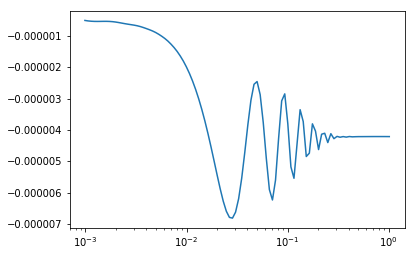

In [1]:
%matplotlib inline
import contextlib
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

from classy import Class


# Generate k array
k_min, k_max = 1e-3, 1e+0
k_gridsize = 100
@contextlib.contextmanager
def disable_numpy_summarization():
    threshold = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=np.inf)
    try:
        yield
    finally:
        np.set_printoptions(threshold=threshold)
k = np.logspace(np.log10((1 - 1e-2)*k_min), np.log10((1 + 1e-2)*k_max), k_gridsize)
with disable_numpy_summarization():
    k_str = np.array2string(k, max_line_width=np.inf,
        formatter={'float': lambda k: f'{k:.3e}'
            .replace('+0', '+').replace('-0', '-').replace('e+0', '')},
        separator=',',
    ).strip('[]')
k = np.fromstring(k_str, sep=',')

# Run CLASS

params = {
    'output': 'dTk',
    'k_output_values': k_str,
    'omega_cdm':0.12038,
    'f_bidm':0.99,
    'm_bidm':1,
    'bidm_type':'powerlaw',
    'n_bidm':-4,
    'a_bidm':5e-4,
    'A_bidm':1.7e-41,
}
cosmo = Class()
cosmo.set(params)
cosmo.compute()
# Get and cleanup background
bg = cosmo.get_background()
bg['a'] = 1/(1 + bg['z'])
indices = np.unique(bg['a'], return_index=True)[1]
for key, val in bg.items():
    bg[key] = val[indices]
# Get and cleanup perturbations
pts = cosmo.get_perturbations()['scalar']
for pt in pts:
    indices = np.unique(pt['a'], return_index=True)[1]
    for key, val in pt.items():
        pt[key] = val[indices]

# Primordial curvature perturbation
derives_parameters = cosmo.get_current_derived_parameters(['A_s', 'n_s', 'alpha_s'])
A_s = derives_parameters['A_s']
n_s = derives_parameters['n_s']
alpha_s = derives_parameters['alpha_s']
k_pivot = 0.05  # 1/Mpc
def zeta(k):
    return (np.pi*np.sqrt(2*A_s)*k**(-3/2)*(k/k_pivot)**((n_s - 1)/2)
        *np.exp(alpha_s/4*np.log(k/k_pivot)**2))

# Get power spectrum
def get_Pk(a, species='b+cdm'):
    P = []
    for i, pt in enumerate(pts):
        a_pt = pt['a']
        # Get rho at this a
        rho = {}
        for s in species.split('+'):
            rho_interp = scipy.interpolate.interp1d(
                np.log(bg['a']), np.log(bg[f'(.)rho_{s}']), kind='cubic')
            rho[s] = lambda a, rho_interp=rho_interp: np.exp(rho_interp(np.log(a)))
        rho_a_pt = {}
        for s in species.split('+'):
            rho_a_pt[s] = rho[s](a_pt)
        # Compute weighted delta
        deltarho_combined = 0
        rho_combined = 0
        for s in species.split('+'):
            deltarho_combined += rho_a_pt[s]*pt[f'delta_{s}']
            rho_combined += rho_a_pt[s]
        delta_combined = deltarho_combined/rho_combined
        # Compute power spectra
        P_a_pt = (delta_combined*zeta(k[i]))**2
        P_a = np.exp(scipy.interpolate.interp1d(np.log(a_pt), np.log(P_a_pt), kind='cubic')(np.log(a)))
        P.append(P_a)
    P = np.array(P)
    return P


#plt.loglog(k, get_Pk(0.5, 'cdm'))
plt.semilogx(k, get_Pk(0.5, 'bidm')/get_Pk(0.5, 'cdm+bidm') - 1)


plt.show()






In [2]:
vals = {}

In [3]:
vals['val1'] = {'k':1, 'b':2}

In [4]:
vals['val2'] = {'k':5, 'b':7}

In [5]:
vals

{'val1': {'k': 1, 'b': 2}, 'val2': {'k': 5, 'b': 7}}

TypeError: unsupported operand type(s) for +=: 'dict' and 'set'